In [1]:
from CVRPSolver import solve, SMALL_CONFIGS, LARGE_CONFIGS
from CVRPSolver.validation import total_traveled_distance
from random import randint, seed
from math import dist
import matplotlib.pyplot as plt

SEED = 0
seed(SEED)

In [2]:
def plot(routes, locations):
    def plot_route(route):
        x = [locations[loc][0] for loc in route]
        y = [locations[loc][1] for loc in route]
        plt.plot(x, y, marker='o', linestyle='-', color='b')

    for route in routes:
        plot_route(route)

    plt.xticks([])
    plt.yticks([])
    depot = locations[0]
    plt.scatter(*depot, color='r', s=100, marker='o', zorder=10)
    plt.show()


def scatter(locations):
    x = [loc[0] for loc in locations]
    y = [loc[1] for loc in locations]
    plt.scatter(x, y, marker='o', linestyle='-', color='b')
    plt.xticks([])
    plt.yticks([])
    depot = locations[0]
    plt.scatter(*depot, color='r', s=100, marker='o', zorder=10)
    plt.show()

# Generation of a small CVRP

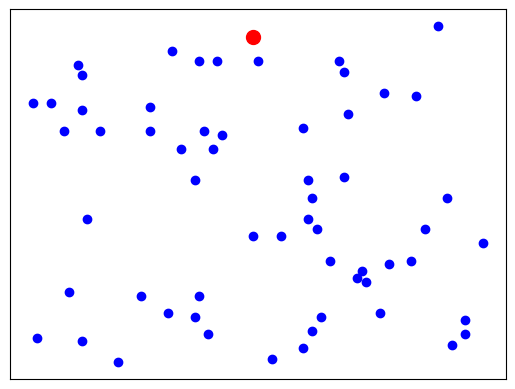

In [3]:
number_of_locations = 60
number_of_vehicles = 8
vehicle_capacity = 100

locations = [(randint(0, 100), randint(0, 100)) for _ in range(number_of_locations)]
distance_matrix = [
    [dist(locations[i], locations[j]) for i in range(number_of_locations)]
    for j in range(number_of_locations)
]

demands = [
    randint(0, 3 * vehicle_capacity * number_of_vehicles // (2 * number_of_locations))
    for _ in range(number_of_locations)
]
scatter(locations)

# Finding a solution using the CVRP solver
- The solver does not garantee an optimal solution, but the output of the solver is usually close to the optimal solution (within ~10% on the instances in `data`) if you give it sufficient time_limit.
> I am using python (instead of pypy) and very low time limit. => That is why I am setting tries to 1 to make up for the low budget. I will show more performent configuration and better budget settings at the end.

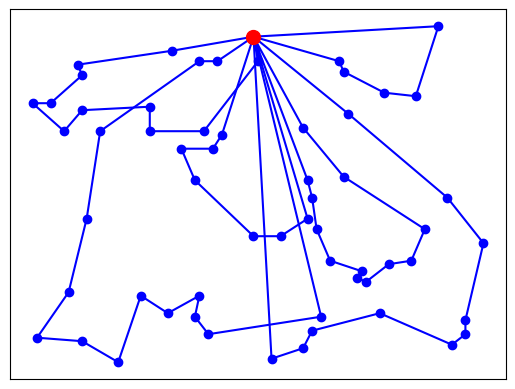

In [4]:
sol = solve(distance_matrix, locations, demands, number_of_vehicles, vehicle_capacity, {"TIME_LIMIT": 30, "SEED": SEED, "TRIES": 1})
plot([[0] + route + [0] for route in sol], locations)

# Performent configurations
I have compiled a list of `performent configurations` for small (less then around 100 locations) and larger problems (around 100 - 1000 locations) using [amltk](https://automl.github.io/amltk/latest/) and instances in `data`. You should try which configuration/s fits your problem the best. Configurations at the beginning of the lists should perform better.

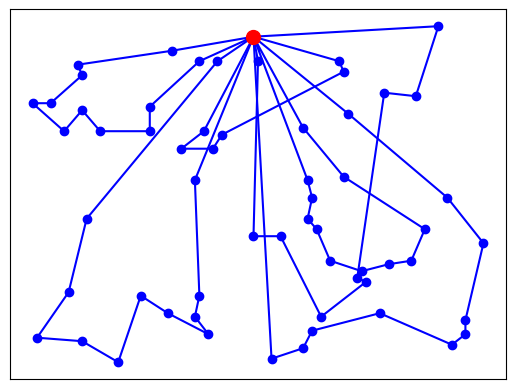

In [5]:
SAMPLE_CONFIG_SMALL = SMALL_CONFIGS[0] | {"TIME_LIMIT": 30, "SEED": SEED, "TRIES": 1}
sol = solve(distance_matrix, locations, demands, number_of_vehicles, vehicle_capacity, SAMPLE_CONFIG_SMALL)
plot([[0] + route + [0] for route in sol], locations)

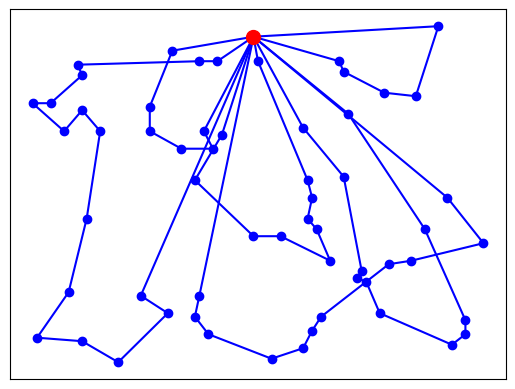

In [6]:
SAMPLE_CONFIG_LARGE = LARGE_CONFIGS[0] | {"TIME_LIMIT": 30, "SEED": SEED, "TRIES": 1}
sol = solve(distance_matrix, locations, demands, number_of_vehicles, vehicle_capacity, SAMPLE_CONFIG_LARGE)
plot([[0] + route + [0] for route in sol], locations)

# Parallel computing
For even better solutions, you should try more configurations with different seeds with time limit around 3-10 minutes (using pypy, probably a bit longer in python).
> Note that I was not able to run pypy as jupyter notebook kernel, so I simply call pypy using a shell, which is not ideal.

In [7]:
import asyncio
from concurrent.futures import ProcessPoolExecutor
from subprocess import Popen
import nest_asyncio
nest_asyncio.apply()  # neccessary for running asyncio in jupyter notebook

from shutil import rmtree
from os import mkdir
from os.path import exists
import json

Best solution index: 3


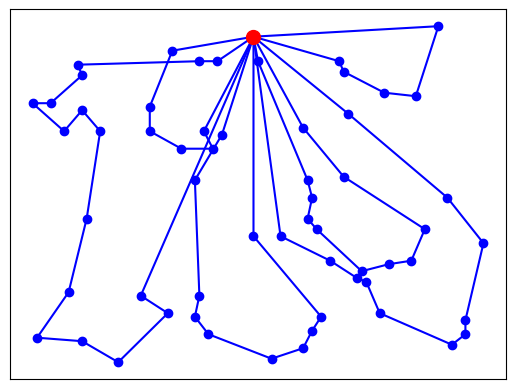

In [8]:
def solve_with_config(idx, config):
    out = f"{OUT}_{idx}.json"
    assert Popen(f"pypy3 ./main.py {IN} {out} '{config}'", shell=True).wait() == 0
    with open(out, "r") as f:
        routes = json.load(f)
    score = total_traveled_distance(routes, distance_matrix)
    return (score, idx, routes)


async def main(loop, n_workers):
    executor = ProcessPoolExecutor(max_workers=n_workers)
    tasks = [
        loop.run_in_executor(executor, solve_with_config, idx, config)
        for idx, config in enumerate(SAMPLE_CONFIGS)
    ]
    return await asyncio.gather(*tasks)


N_WORKERS = 2

# You should try even more configurations and seeds.
# You should also try a bit higher time limit for larger problems.
SAMPLE_CONFIGS = [
    config | {"TIME_LIMIT": 3*60, "SEED": seed}
    for config in SMALL_CONFIGS[:5]
    for seed in (0, 42)
]

TEMP = "./temp"
IN = f"{TEMP}/cvrp_45.json"
OUT = f"{TEMP}/cvrp_45_solution"
PROBLEM = {
    "Coordinates": locations,
    "LocationDemands": demands,
    "DistanceMatrix": distance_matrix,
    "VehicleCapacity": vehicle_capacity,
    "NumberOfVehicles": number_of_vehicles,
    "GlobalBestTotalDistance": None
}
if not exists(TEMP):
    mkdir(TEMP)
with open(IN, "w") as f:
    json.dump(PROBLEM, f)
loop = asyncio.get_event_loop()
score, idx, routes = min(loop.run_until_complete(main(loop, N_WORKERS)))
print(f"Best solution index: {idx}")
rmtree(TEMP)
plot(routes, locations)
